In [1]:
import pandas as pd
import requests
import json
import time
import numpy as np
from datetime import datetime
#Show all columns
pd.set_option('display.max_columns', None)
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
from scipy import stats

import sklearn
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression, RidgeClassifier 
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from functools import reduce

In [2]:
All_years = [str(2010 + i) for i in range(13)]
timeline_dict = dict()
for year in All_years:
    df_temp = pd.read_excel('All_years/' + year + '.xlsx')
    df_temp.sort_values(by = 'Date', ascending = True, inplace = True)
    timeline_dict[year] = df_temp

C:\Users\Khoa Truong\anaconda3\envs\data\lib\site-packages\openpyxl\worksheet\_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


In [3]:
Columns = ['Location', 'Tournament', 'Date', 'Series', 'Environment', 'Round', 'Best of', 'Winner', 'Loser', 
           'WPts', 'LPts', 'Comment']
Cleaned_timeline = dict()
for year, df in timeline_dict.items():
    df['Environment'] = df['Court'] + ' ' + df['Surface']
    df = df.dropna(subset = ['WPts', 'LPts'])
    Cleaned_timeline[year] = df.loc[df['Comment'] == 'Completed'].copy()[Columns]

In [4]:
def win_rate(key, Cleaned_timeline):
    Series_list = ['ATP250', 'Grand Slam', 'ATP500', 'Masters 1000']
    series_dict = dict()
    Env_list = ['Outdoor Hard', 'Indoor Hard', 'Outdoor Clay', 'Indoor Clay', 'Outdoor Grass']
    Env_dict = {'Outdoor Hard': 'OH', 'Indoor Hard': 'IH', 'Outdoor Clay': 'OC', 
                'Indoor Clay': 'IC', 'Outdoor Grass': 'OG'}
    features = list()
    for env, abbrv in Env_dict.items():
        ft = abbrv
        features.append(ft)
    
    df = Cleaned_timeline[key]
    ##This is the main dataframe
    winners = list(df['Winner'].unique())
    losers = list(df['Loser'].unique())
    current_players = np.unique(winners + losers)
    data = {player_name: [0] * len(features) for player_name in current_players}
    df_temp = pd.DataFrame.from_dict(data, orient = 'index', columns = features)
    df_temp = df_temp.reset_index().rename(columns = {'index': 'Player Name'})
    
    for serie in Series_list:
        df_serie = df_temp.copy()
        for env in Env_list:
            for player in current_players:
            ##tr: Number of tournaments the player participates in that specific series and sepcific environment
                tr = len(df.loc[(df['Series'] == serie) & (df['Environment'] == env)
                      & ((df['Winner'] == player) | (df['Loser'] == player))]['Tournament'].unique())
                number_of_rounds = len(df.loc[(df['Series'] == serie) & (df['Environment'] == env)]['Round'].unique())
                wins = df.loc[(df['Series'] == serie) & (df['Environment'] == env) & (df['Winner'] == player)].shape[0]

                ###Total_rounds: all the rounds that are in the specific tournaments
                total_rounds = number_of_rounds * tr
                win_prob = 0
                if total_rounds != 0:
                    win_prob = wins/total_rounds
                df_serie.loc[df_serie['Player Name'] == player, Env_dict[env]] = win_prob
        series_dict[serie] = df_serie
    return series_dict

In [5]:
All_years = [str(2010 + i) for i in range(13)]
yearly_stats = dict()
###Apply this function to all the timeline dataframes
for year in All_years:
    series_dict = win_rate(year, Cleaned_timeline)
    yearly_stats[year] = series_dict

In [6]:
###We concat based on 2 year time lags
lags = 2
lag_stats = dict()
Series_list = ['ATP250', 'Grand Slam', 'ATP500', 'Masters 1000']

for year in All_years:
    start_year = int(year)
    end_year = int(year) + lags - 1
    if end_year == 2023:
        break
    year_list = list(range(start_year, end_year+1))
    key = str(year_list[0]) + '-' + str(year_list[-1])
    serie_dict2 = dict()
    for serie in Series_list:
        df_list = list()
        for year in year_list:
            idx = year_list.index(year)
            df_temp = yearly_stats[str(year)][serie].copy()
            df_temp = df_temp.add_suffix('_' + str(idx + 1))
            df_temp['Player Name'] = df_temp['Player Name_' + str(idx + 1)]
            df_temp = df_temp.drop('Player Name_' + str(idx + 1), axis = 1)
            df_list.append(df_temp)
        merged_df = reduce(lambda left, right: pd.merge(left, right, on='Player Name', how='outer'), df_list)
        merged_df = merged_df.fillna(0)
        serie_dict2[serie] = merged_df
    lag_stats[key] = serie_dict2

In [7]:
##df_time: represent a dataframe from cleaned timeline
##data_dict: represents a dictionary of data given a time period (lags = 2)
##this function prep the data to ensure that it is ready for ML
##We are not predicting masters cup
##key: represent the period of the lag data

def prep_data(df_time, data_dict, key, lags = 2):
    ###Preping up a new df from df_time
    df = df_time.copy()[['Winner', 'Loser', 'Series', 'Environment', 'WPts', 'LPts']]

    df[['player 0', 'player 1', 'Pts_0', 'Pts_1']] = df.apply(lambda row: pd.Series([row['Winner'], row['Loser'], row['WPts'], row['LPts']]) 
                                                              if np.random.permutation([0, 1])[0] == 0 
                                                              else pd.Series([row['Loser'], row['Winner'], row['LPts'], row['WPts']]), axis=1)
    ###We skip the masters cup
    df = df[df['Series'] != 'Masters Cup']
    for i in range(lags):
        df['p0_' + str(i+1)] = 0
    for j in range(lags):
        df['p1_' + str(j+1)] = 0
    df['Match'] = 0
    
    Env_dict = {'Outdoor Hard': 'OH', 'Indoor Hard': 'IH', 'Outdoor Clay': 'OC', 
                'Indoor Clay': 'IC', 'Outdoor Grass': 'OG'}
    
    ###Concat the previous win rate
    for i in range(df.shape[0]):
        serie = df.iloc[i]['Series']
        env = df.iloc[i]['Environment']
        player_0 = df.iloc[i]['player 0']
        player_1 = df.iloc[i]['player 1']
        df_serie = data_dict[serie]

        ###Generate a list of years
        start_year, end_year = key.split('-')
        year_list = list(range(int(start_year), int(end_year)+1))

        for j in range(len(year_list)):
            check = df_serie.loc[(df_serie['Player Name'] == player_0)][Env_dict[env] + '_' + str(j + 1)].shape[0]
            prob_0 = 0
            if check != 0:
                prob_0 = df_serie.loc[(df_serie['Player Name'] == player_0)][Env_dict[env] + '_' + str(j + 1)].iloc[0]
            col_index0 = df.columns.get_loc('p0_' + str(j+1))
            df.iloc[i, col_index0] = prob_0

            check = df_serie.loc[(df_serie['Player Name'] == player_1)][Env_dict[env] + '_' + str(j + 1)].shape[0]
            prob_1 = 0
            if check != 0:
                prob_1 = df_serie.loc[(df_serie['Player Name'] == player_1)][Env_dict[env] + '_' + str(j + 1)].iloc[0]
            col_index1 = df.columns.get_loc('p1_' + str(j+1))
            df.iloc[i, col_index1] = prob_1
    
    df.loc[(df['Winner'] == df['player 0']), 'Match'] = 0
    df.loc[(df['Winner'] == df['player 1']), 'Match'] = 1
    
    env_df = pd.get_dummies(df['Environment'], prefix = 'env')
    series_df = pd.get_dummies(df['Series'], prefix = 'serie')
    df_ML = pd.concat([df.copy()[['Pts_0','Pts_1','p0_1', 'p0_2', 'p1_1', 'p1_2']], 
                       env_df, series_df, df.copy()[['Match']]], axis = 1)
    return df_ML

In [8]:
ML_data_dict = dict()
for year in All_years[lags:]:
    df_time = Cleaned_timeline[year].reset_index(drop = True)
    key = list()
    for i in range(lags):
        y = int(year) - (lags - i)
        key.append(y)
    key = str(key[0]) + '-' + str(key[-1])
    data_dict = lag_stats[key]
    df_ML = prep_data(df_time, data_dict, key, lags = 2)
    ML_data_dict[year] = df_ML

In [9]:
ML_data_dict['2018']

,Pts_0,Pts_1,p0_1,p0_2,p1_1,p1_2,env_Indoor Clay,env_Indoor Hard,env_Outdoor Clay,env_Outdoor Grass,env_Outdoor Hard,serie_ATP250,serie_ATP500,serie_Grand Slam,serie_Masters 1000,Match
0,315.0,1675.0,0.111111,0.125000,0.333333,0.083333,0,0,0,0,1,1,0,0,0,0
1,245.0,1055.0,0.000000,0.083333,0.083333,0.291667,0,0,0,0,1,1,0,0,0,0
2,523.0,1.0,0.000000,0.000000,0.055556,0.000000,0,0,0,0,1,1,0,0,0,0
3,590.0,630.0,0.000000,0.000000,0.000000,0.333333,0,0,0,0,1,1,0,0,0,1
4,693.0,616.0,0.083333,0.000000,0.000000,0.000000,0,0,0,0,1,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2534,4050.0,7445.0,0.500000,0.333333,0.333333,0.000000,0,1,0,0,0,0,0,0,1,1
2535,6260.0,3210.0,0.000000,0.000000,0.166667,0.000000,0,1,0,0,0,0,0,0,1,0
2536,1845.0,3825.0,0.000000,0.000000,0.000000,0.166667,0,1,0,0,0,0,0,0,1,0
2537,7445.0,6260.0,0.333333,0.000000,0.000000,0.000000,0,1,0,0,0,0,0,0,1,0


In [10]:
def ML_data(splits, scaler, df_ML, features, target):
    splits = 5
    kf = KFold(n_splits = splits, shuffle=True, random_state = 0)

    train_data_dict = dict()
    test_data_dict = dict()
    scaled_train_set = dict()
    scaled_test_set = dict()
    
    train_target_dict = dict()
    test_target_dict = dict()

    Count = 1
    for i, (train_index, test_index) in enumerate(kf.split(df_ML)):
        train_data = df_ML.iloc[train_index][features]
        test_data = df_ML.iloc[test_index][features]
        train_data_dict['Fold ' + str(i + 1)] = train_data
        test_data_dict['Fold ' + str(i + 1)] = test_data
        
        the_scaler = scaler
        scaled_train_set['Fold ' + str(i + 1)] = the_scaler.fit_transform(train_data)
        scaled_test_set['Fold ' + str(i + 1)] = the_scaler.transform(test_data)
        
        train_target = df_ML.iloc[train_index][target]
        test_target = df_ML.iloc[test_index][target]
        train_target_dict['Fold ' + str(i + 1)] = train_target
        test_target_dict['Fold ' + str(i + 1)] = test_target
        Count += 1
    return train_data_dict, scaled_train_set, train_target_dict, test_data_dict, scaled_test_set, test_target_dict

## Data analysis

In [11]:
df_2017 = Cleaned_timeline['2017'].copy()
df_2017 = df_2017[df_2017['Series'] != 'Masters Cup']
df_2017

,Location,Tournament,Date,Series,Environment,Round,Best of,Winner,Loser,WPts,LPts,Comment
0,Brisbane,Brisbane International,2017-01-01,ATP250,Outdoor Hard,1st Round,3,Thompson J.,Ymer E.,689,372.0,Completed
56,Doha,Qatar Exxon Mobil Open,2017-01-02,ATP250,Outdoor Hard,1st Round,3,Almagro N.,Lorenzi P.,1013,1090.0,Completed
57,Doha,Qatar Exxon Mobil Open,2017-01-02,ATP250,Outdoor Hard,1st Round,3,Djokovic N.,Struff J.L.,11780,758.0,Completed
58,Doha,Qatar Exxon Mobil Open,2017-01-02,ATP250,Outdoor Hard,1st Round,3,Zeballos H.,Mayer F.,722,903.0,Completed
59,Doha,Qatar Exxon Mobil Open,2017-01-02,ATP250,Outdoor Hard,1st Round,3,Goffin D.,Haase R.,2750,795.0,Completed
...,...,...,...,...,...,...,...,...,...,...,...,...
2613,Paris,BNP Paribas Masters,2017-11-03,Masters 1000,Indoor Hard,Quarterfinals,3,Benneteau J.,Cilic M.,634,4185.0,Completed
2611,Paris,BNP Paribas Masters,2017-11-03,Masters 1000,Indoor Hard,Quarterfinals,3,Isner J.,Del Potro J.M.,2505,2435.0,Completed
2615,Paris,BNP Paribas Masters,2017-11-04,Masters 1000,Indoor Hard,Semifinals,3,Krajinovic F.,Isner J.,681,2505.0,Completed
2616,Paris,BNP Paribas Masters,2017-11-04,Masters 1000,Indoor Hard,Semifinals,3,Sock J.,Benneteau J.,1945,634.0,Completed


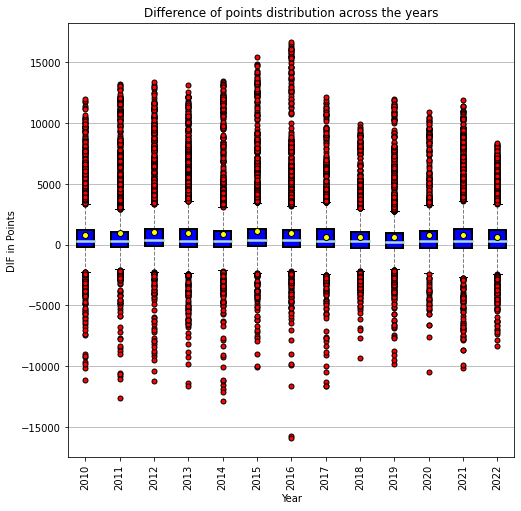

In [12]:
###Plot the difference of points = Winners - Losers
###Switch showfliers to False to see a better distribution
yearly_dif = dict()
for year, df in Cleaned_timeline.items():
    yearly_dif[year] = (df['WPts'] - df['LPts'])

fig, ax = plt.subplots(figsize = (8, 8))
boxprops = dict(linestyle='-', linewidth=2, color='black')
flierprops = dict(marker='o', markersize=5, markerfacecolor='red')
medianprops = dict(linestyle='-', linewidth=2.5, color='lightblue')
meanprops = dict(marker='o', markeredgecolor='black', markerfacecolor='yellow')
whiskerprops = dict(linestyle='--', linewidth=1, color='gray')

bp = ax.boxplot(yearly_dif.values(), showfliers=True, vert=True, showmeans=True,
                boxprops=boxprops, flierprops=flierprops, medianprops=medianprops,
                meanprops=meanprops, whiskerprops=whiskerprops, patch_artist=True)

colors = ['blue']*len(yearly_dif.keys())
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)

ax.set_xticklabels(yearly_dif.keys())
ax.set_ylabel("DIF in Points")
ax.set_xlabel("Year")

plt.grid(axis='y')
plt.xticks(rotation='vertical')
plt.title("Difference of points distribution across the years")
plt.show()

In [13]:
yearlydif_data = dict()
for year, dif in yearly_dif.items():
    mean = yearly_dif[year].mean()
    median = yearly_dif[year].median()
    std = yearly_dif[year].std(ddof = 1)
    yearlydif_data[year] = [mean, median, std]
    
yearly_data = pd.DataFrame.from_dict(yearlydif_data, orient='index', columns= ['mean_dif', 'median_df', 'std_df'])
yearly_data

,mean_dif,median_df,std_df
2010,810.189231,332.0,2318.678456
2011,961.320858,340.0,2650.452922
2012,1046.502404,352.5,2658.066637
2013,983.159905,323.5,2622.090827
2014,916.128721,331.5,2651.011659
2015,1123.846765,396.0,2730.946750
2016,954.412698,348.0,2772.211548
2017,660.492478,315.5,2105.005610
2018,610.904072,287.5,1908.321084
2019,635.958234,223.5,2187.073993


#### Does the win rate from the last 2 years matter?

In [14]:
df = ML_data_dict['2017'].copy()
df

,Pts_0,Pts_1,p0_1,p0_2,p1_1,p1_2,env_Indoor Clay,env_Indoor Hard,env_Outdoor Clay,env_Outdoor Grass,env_Outdoor Hard,serie_ATP250,serie_ATP500,serie_Grand Slam,serie_Masters 1000,Match
0,689.0,372.0,0.000000,0.000000,0.166667,0.000000,0,0,0,0,1,1,0,0,0,0
1,1090.0,1013.0,0.000000,0.055556,0.000000,0.166667,0,0,0,0,1,1,0,0,0,1
2,11780.0,758.0,0.333333,0.833333,0.166667,0.083333,0,0,0,0,1,1,0,0,0,0
3,903.0,722.0,0.000000,0.000000,0.000000,0.250000,0,0,0,0,1,1,0,0,0,1
4,2750.0,795.0,0.166667,0.083333,0.000000,0.166667,0,0,0,0,1,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2506,634.0,4185.0,0.000000,0.000000,0.000000,0.500000,0,1,0,0,0,0,0,0,1,0
2507,2435.0,2505.0,0.000000,0.000000,0.333333,0.833333,0,1,0,0,0,0,0,0,1,1
2508,2505.0,681.0,0.333333,0.833333,0.000000,0.000000,0,1,0,0,0,0,0,0,1,1
2509,1945.0,634.0,0.000000,0.500000,0.000000,0.000000,0,1,0,0,0,0,0,0,1,0


In [15]:
df['Winner_rate_1'] = df.apply(lambda row: row['p1_1'] if row['Match'] == 1 else row['p0_1'], axis=1)
df['Winner_rate_2'] = df.apply(lambda row: row['p1_2'] if row['Match'] == 1 else row['p0_2'], axis=1)
df['Loser_rate_1'] = df.apply(lambda row: row['p0_1'] if row['Match'] == 1 else row['p1_1'], axis=1)
df['Loser_rate_2'] = df.apply(lambda row: row['p0_2'] if row['Match'] == 1 else row['p1_2'], axis=1)

In [16]:
df

,Pts_0,Pts_1,p0_1,p0_2,p1_1,p1_2,env_Indoor Clay,env_Indoor Hard,env_Outdoor Clay,env_Outdoor Grass,env_Outdoor Hard,serie_ATP250,serie_ATP500,serie_Grand Slam,serie_Masters 1000,Match,Winner_rate_1,Winner_rate_2,Loser_rate_1,Loser_rate_2
0,689.0,372.0,0.000000,0.000000,0.166667,0.000000,0,0,0,0,1,1,0,0,0,0,0.000000,0.000000,0.166667,0.000000
1,1090.0,1013.0,0.000000,0.055556,0.000000,0.166667,0,0,0,0,1,1,0,0,0,1,0.000000,0.166667,0.000000,0.055556
2,11780.0,758.0,0.333333,0.833333,0.166667,0.083333,0,0,0,0,1,1,0,0,0,0,0.333333,0.833333,0.166667,0.083333
3,903.0,722.0,0.000000,0.000000,0.000000,0.250000,0,0,0,0,1,1,0,0,0,1,0.000000,0.250000,0.000000,0.000000
4,2750.0,795.0,0.166667,0.083333,0.000000,0.166667,0,0,0,0,1,1,0,0,0,0,0.166667,0.083333,0.000000,0.166667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2506,634.0,4185.0,0.000000,0.000000,0.000000,0.500000,0,1,0,0,0,0,0,0,1,0,0.000000,0.000000,0.000000,0.500000
2507,2435.0,2505.0,0.000000,0.000000,0.333333,0.833333,0,1,0,0,0,0,0,0,1,1,0.333333,0.833333,0.000000,0.000000
2508,2505.0,681.0,0.333333,0.833333,0.000000,0.000000,0,1,0,0,0,0,0,0,1,1,0.000000,0.000000,0.333333,0.833333
2509,1945.0,634.0,0.000000,0.500000,0.000000,0.000000,0,1,0,0,0,0,0,0,1,0,0.000000,0.500000,0.000000,0.000000


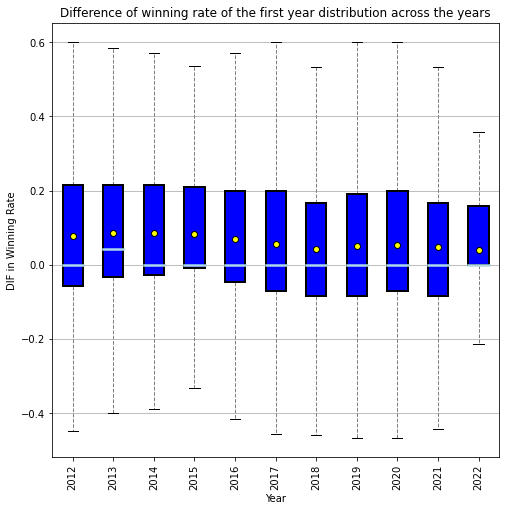

In [17]:
yearly_dif1 = dict()
yearly_dif2 = dict()
for year, df in ML_data_dict.items():
    df_temp = df.copy()
    df_temp['Winner_rate_1'] = df_temp.apply(lambda row: row['p1_1'] if row['Match'] == 1 else row['p0_1'], axis=1)
    df_temp['Winner_rate_2'] = df_temp.apply(lambda row: row['p1_2'] if row['Match'] == 1 else row['p0_2'], axis=1)
    df_temp['Loser_rate_1'] = df_temp.apply(lambda row: row['p0_1'] if row['Match'] == 1 else row['p1_1'], axis=1)
    df_temp['Loser_rate_2'] = df_temp.apply(lambda row: row['p0_2'] if row['Match'] == 1 else row['p1_2'], axis=1)
    yearly_dif1[year] = df_temp['Winner_rate_1'] - df_temp['Loser_rate_1']
    yearly_dif2[year] = df_temp['Winner_rate_2'] - df_temp['Loser_rate_2']

fig, ax = plt.subplots(figsize = (8, 8))
boxprops = dict(linestyle='-', linewidth=2, color='black')
flierprops = dict(marker='o', markersize=5, markerfacecolor='red')
medianprops = dict(linestyle='-', linewidth=2.5, color='lightblue')
meanprops = dict(marker='o', markeredgecolor='black', markerfacecolor='yellow')
whiskerprops = dict(linestyle='--', linewidth=1, color='gray')

bp = ax.boxplot(yearly_dif1.values(), showfliers=False, vert=True, showmeans=True,
                boxprops=boxprops, flierprops=flierprops, medianprops=medianprops,
                meanprops=meanprops, whiskerprops=whiskerprops, patch_artist=True)

colors = ['blue']*len(yearly_dif1.keys())
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)

ax.set_xticklabels(yearly_dif1.keys())
ax.set_ylabel("DIF in Winning Rate")
ax.set_xlabel("Year")

plt.grid(axis='y')
plt.xticks(rotation='vertical')
plt.title("Difference of winning rate of the first year distribution across the years")
plt.show()

In [28]:
yearlydif1_data = dict()
for year, dif in yearly_dif1.items():
    mean = yearly_dif1[year].mean()
    median = yearly_dif1[year].median()
    std = yearly_dif1[year].std(ddof = 1)
    yearlydif1_data[year] = [mean, median, std]
    
yearly_data1 = pd.DataFrame.from_dict(yearlydif1_data, orient='index', columns= ['mean_dif', 'median_df', 'std_df'])
yearly_data1

,mean_dif,median_df,std_df
2012,0.078385,0.000000,0.274934
2013,0.086625,0.041667,0.258362
2014,0.085037,0.000000,0.278843
2015,0.083304,0.000000,0.259459
2016,0.070075,0.000000,0.260646
2017,0.054785,0.000000,0.256274
2018,0.041019,0.000000,0.254179
2019,0.050345,0.000000,0.277453
2020,0.053937,0.000000,0.242453
2021,0.047642,0.000000,0.259105


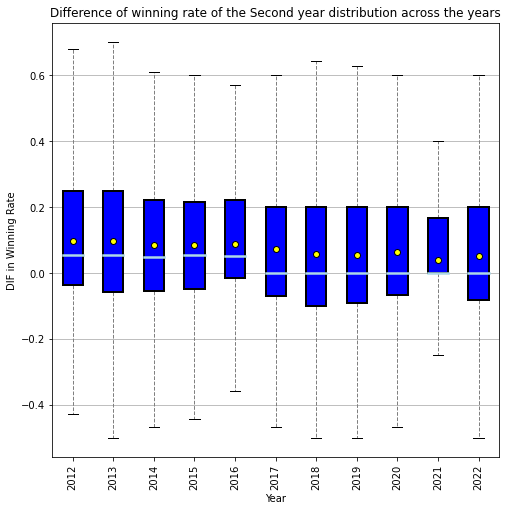

In [35]:
fig, ax = plt.subplots(figsize = (8, 8))
boxprops = dict(linestyle='-', linewidth=2, color='black')
flierprops = dict(marker='o', markersize=5, markerfacecolor='red')
medianprops = dict(linestyle='-', linewidth=2.5, color='lightblue')
meanprops = dict(marker='o', markeredgecolor='black', markerfacecolor='yellow')
whiskerprops = dict(linestyle='--', linewidth=1, color='gray')

bp = ax.boxplot(yearly_dif2.values(), showfliers=False, vert=True, showmeans=True,
                boxprops=boxprops, flierprops=flierprops, medianprops=medianprops,
                meanprops=meanprops, whiskerprops=whiskerprops, patch_artist=True)

colors = ['blue']*len(yearly_dif2.keys())
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)

ax.set_xticklabels(yearly_dif2.keys())
ax.set_ylabel("DIF in Winning Rate")
ax.set_xlabel("Year")

plt.grid(axis='y')
plt.xticks(rotation='vertical')
plt.title("Difference of winning rate of the Second year distribution across the years")
plt.show()

In [36]:
yearlydif2_data = dict()
for year, dif in yearly_dif2.items():
    mean = yearly_dif2[year].mean()
    median = yearly_dif2[year].median()
    std = yearly_dif2[year].std(ddof = 1)
    yearlydif2_data[year] = [mean, median, std]
    
yearly_data2 = pd.DataFrame.from_dict(yearlydif2_data, orient='index', columns= ['mean_dif', 'median_df', 'std_df'])
yearly_data2

,mean_dif,median_df,std_df
2012,0.095771,0.055556,0.264182
2013,0.095894,0.053333,0.287809
2014,0.083438,0.047619,0.265556
2015,0.084351,0.055556,0.260510
2016,0.087368,0.050000,0.264849
2017,0.071233,0.000000,0.262785
2018,0.057457,0.000000,0.278960
2019,0.054216,0.000000,0.268446
2020,0.064411,0.000000,0.256681
2021,0.039655,0.000000,0.261631


## Predicting the matches

In [19]:
def player_ml(model, train_data_dict, train_target_dict, test_data_dict, test_target_dict, verbose = 0):
    Test_accuracy_list = list()
    Test_precision_list = list()
    Train_accuracy_list = list()
    Test_recall_list = list()

    for i in range(5):
        train_set = train_data_dict['Fold ' + str(i + 1)]
        train_target = train_target_dict['Fold ' + str(i + 1)].to_numpy().ravel()
        test_set = test_data_dict['Fold ' + str(i + 1)]
        test_target = test_target_dict['Fold ' + str(i + 1)].to_numpy().ravel()
        model.fit(train_set, train_target)
        train_accuracy = model.score(train_set, train_target)
        
        test_observed = test_target_dict['Fold ' + str(i + 1)].to_numpy().ravel()
        test_predicted = model.predict(test_set)
        accuracy = accuracy_score(test_observed, test_predicted)
        precision = precision_score(test_observed, test_predicted)
        recall = recall_score(test_observed, test_predicted)

        Test_accuracy_list.append(accuracy)
        Test_precision_list.append(precision)
        Train_accuracy_list.append(train_accuracy)
        Test_recall_list.append(recall)
        
        if verbose == 1:
            print("Fold " + str(i + 1) + " Test Accuracy score:", np.round(accuracy, 4))
            print("Fold " + str(i + 1) + " Test Precision score:", np.round(precision, 4))
            print("Fold " + str(i + 1) + " Test Recall score:", np.round(recall, 4))
            print()
    dif = np.round(sum(Train_accuracy_list)/len(Train_accuracy_list), 4) - np.round(sum(Test_accuracy_list)/len(Test_accuracy_list), 4)
    dif = np.round(dif * 100, 2)
    if verbose == 1:
        print("The average Train Accuracy : ", np.round(sum(Train_accuracy_list)/len(Train_accuracy_list), 4))
        print("The average Test Accuracy : ", np.round(sum(Test_accuracy_list)/len(Test_accuracy_list), 4))
        print("The average Test Precision: ", np.round(sum(Test_precision_list)/len(Test_precision_list), 4))
        print("The average Test Recall: ", np.round(sum(Test_recall_list)/len(Test_recall_list), 4))
        print("Difference between Train vs. Test Accuracy: ", dif, "%")
    avg_Train_accuracy = np.round(sum(Train_accuracy_list)/len(Train_accuracy_list), 4)
    avg_Test_accuracy = np.round(sum(Test_accuracy_list)/len(Test_accuracy_list), 4)
    avg_Test_precision = np.round(sum(Test_precision_list)/len(Test_precision_list), 4)
    avg_Test_recall = np.round(sum(Test_recall_list)/len(Test_recall_list), 4)
    return (avg_Train_accuracy, avg_Test_accuracy, avg_Test_precision, avg_Test_recall, dif)

In [20]:
lr_performance = dict()
NB_performance = dict()
qda_performance = dict()
rc_performance = dict()

NB = GaussianNB(priors = [0.50, 0.50])
lr = LogisticRegression(penalty = 'none', solver = 'newton-cg')
qda = QuadraticDiscriminantAnalysis()
rc = RidgeClassifier()

for key, df_ML in ML_data_dict.items():
    
    ###Prep the data for ML/DL with 5 Folds-cv
    splits = 5
    scaler = MinMaxScaler()
    features = df_ML.iloc[:, :-1].columns
    target = df_ML.iloc[:, -1:].columns
    all_dicts = ML_data(splits, scaler, df_ML, features, target)
    train_data_dict = all_dicts[0] 
    scaled_train_set = all_dicts[1]
    train_target_dict = all_dicts[2]
    
    test_data_dict = all_dicts[3]
    scaled_test_set = all_dicts[4]
    test_target_dict = all_dicts[5]
    
    ###Run the ml on data
    avg_Train_accuracy, avg_Test_accuracy, avg_Test_precision, avg_Test_recall, dif = player_ml(lr, scaled_train_set, train_target_dict, scaled_test_set, test_target_dict, verbose = 0)
    lr_performance[key] = [avg_Train_accuracy, avg_Test_accuracy, avg_Test_precision, avg_Test_recall, dif]
    
    avg_Train_accuracy, avg_Test_accuracy, avg_Test_precision, avg_Test_recall, dif = player_ml(NB, scaled_train_set, train_target_dict, scaled_test_set, test_target_dict, verbose = 0)
    NB_performance[key] = [avg_Train_accuracy, avg_Test_accuracy, avg_Test_precision, avg_Test_recall, dif]
    
    avg_Train_accuracy, avg_Test_accuracy, avg_Test_precision, avg_Test_recall, dif = player_ml(qda, scaled_train_set, train_target_dict, scaled_test_set, test_target_dict, verbose = 0)
    qda_performance[key] = [avg_Train_accuracy, avg_Test_accuracy, avg_Test_precision, avg_Test_recall, dif]
    
    avg_Train_accuracy, avg_Test_accuracy, avg_Test_precision, avg_Test_recall, dif = player_ml(rc, scaled_train_set, train_target_dict, scaled_test_set, test_target_dict, verbose = 0)
    rc_performance[key] = [avg_Train_accuracy, avg_Test_accuracy, avg_Test_precision, avg_Test_recall, dif]

C:\Users\Khoa Truong\AppData\Roaming\Python\Python39\site-packages\sklearn\discriminant_analysis.py:808: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\Khoa Truong\AppData\Roaming\Python\Python39\site-packages\sklearn\discriminant_analysis.py:808: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\Khoa Truong\AppData\Roaming\Python\Python39\site-packages\sklearn\discriminant_analysis.py:808: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\Khoa Truong\AppData\Roaming\Python\Python39\site-packages\sklearn\discriminant_analysis.py:808: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\Khoa Truong\AppData\Roaming\Python\Python39\site-packages\sklearn\discriminant_analysis.py:808: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\Khoa Truong\AppData\Roaming\Python\Python39\site-packages\sklearn\

C:\Users\Khoa Truong\AppData\Roaming\Python\Python39\site-packages\sklearn\discriminant_analysis.py:808: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\Khoa Truong\AppData\Roaming\Python\Python39\site-packages\sklearn\discriminant_analysis.py:808: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\Khoa Truong\AppData\Roaming\Python\Python39\site-packages\sklearn\discriminant_analysis.py:808: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\Khoa Truong\AppData\Roaming\Python\Python39\site-packages\sklearn\discriminant_analysis.py:808: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\Khoa Truong\AppData\Roaming\Python\Python39\site-packages\sklearn\discriminant_analysis.py:808: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\Khoa Truong\AppData\Roaming\Python\Python39\site-packages\sklearn\

In [21]:
lr_performance

{'2012': [0.6839, 0.6731, 0.6717, 0.6932, 1.08],
 '2013': [0.6671, 0.6575, 0.6567, 0.6421, 0.96],
 '2014': [0.674, 0.6626, 0.6653, 0.6547, 1.14],
 '2015': [0.6876, 0.6733, 0.6818, 0.6579, 1.43],
 '2016': [0.6824, 0.6731, 0.6679, 0.7329, 0.93],
 '2017': [0.6561, 0.6519, 0.6467, 0.6671, 0.42],
 '2018': [0.6358, 0.618, 0.6171, 0.5685, 1.78],
 '2019': [0.6307, 0.6314, 0.6269, 0.636, -0.07],
 '2020': [0.6345, 0.625, 0.6284, 0.6141, 0.95],
 '2021': [0.6291, 0.6135, 0.6142, 0.6751, 1.56],
 '2022': [0.6407, 0.6304, 0.64, 0.5187, 1.03]}

In [22]:
NB_performance

{'2012': [0.6586, 0.6433, 0.6247, 0.739, 1.53],
 '2013': [0.6391, 0.6387, 0.6181, 0.6975, 0.04],
 '2014': [0.6452, 0.6436, 0.669, 0.5693, 0.16],
 '2015': [0.6571, 0.6498, 0.68, 0.5763, 0.73],
 '2016': [0.651, 0.6371, 0.6497, 0.6799, 1.39],
 '2017': [0.6348, 0.6296, 0.6499, 0.5566, 0.52],
 '2018': [0.5952, 0.5806, 0.5669, 0.6, 1.46],
 '2019': [0.594, 0.5854, 0.5672, 0.7005, 0.86],
 '2020': [0.6244, 0.6044, 0.6199, 0.5304, 2.0],
 '2021': [0.5896, 0.5703, 0.5843, 0.572, 1.93],
 '2022': [0.6107, 0.5905, 0.581, 0.5308, 2.02]}

In [23]:
qda_performance

{'2012': [0.6274, 0.6123, 0.6001, 0.7024, 1.51],
 '2013': [0.6119, 0.5942, 0.6002, 0.5435, 1.77],
 '2014': [0.5993, 0.5971, 0.6272, 0.4935, 0.22],
 '2015': [0.624, 0.6158, 0.6653, 0.4854, 0.82],
 '2016': [0.6253, 0.594, 0.6035, 0.6502, 3.13],
 '2017': [0.5904, 0.5794, 0.6153, 0.4878, 1.1],
 '2018': [0.5785, 0.5711, 0.5517, 0.643, 0.74],
 '2019': [0.5854, 0.571, 0.5633, 0.5684, 1.44],
 '2020': [0.6079, 0.5954, 0.5808, 0.6622, 1.25],
 '2021': [0.5753, 0.5473, 0.5588, 0.5578, 2.8],
 '2022': [0.5861, 0.5826, 0.5711, 0.5868, 0.35]}

In [24]:
rc_performance

{'2012': [0.6793, 0.6675, 0.6668, 0.6852, 1.18],
 '2013': [0.6618, 0.6519, 0.6527, 0.6314, 0.99],
 '2014': [0.6646, 0.6578, 0.6609, 0.6498, 0.68],
 '2015': [0.6769, 0.6633, 0.674, 0.6421, 1.36],
 '2016': [0.6741, 0.6667, 0.658, 0.7446, 0.74],
 '2017': [0.654, 0.6471, 0.6411, 0.6671, 0.69],
 '2018': [0.632, 0.6113, 0.6126, 0.5509, 2.07],
 '2019': [0.6292, 0.6298, 0.6291, 0.6208, -0.06],
 '2020': [0.6363, 0.6217, 0.6256, 0.607, 1.46],
 '2021': [0.6278, 0.6135, 0.6113, 0.6915, 1.43],
 '2022': [0.6384, 0.6265, 0.642, 0.4971, 1.19]}

In [25]:
cols = ['Train_accuracy', 'Test_accuracy', 'Test_precision', 'Test_recall', 'dif']
df_lr = pd.DataFrame.from_dict(lr_performance, orient='index', columns= ['lr_' + a for a in cols])
df_NB = pd.DataFrame.from_dict(NB_performance, orient='index', columns= ['NB_' + a for a in cols])
df_qda = pd.DataFrame.from_dict(qda_performance, orient='index', columns= ['qda_' + a for a in cols])
df_rc = pd.DataFrame.from_dict(rc_performance, orient='index', columns = ['rc_' + a for a in cols])

### Plot the result

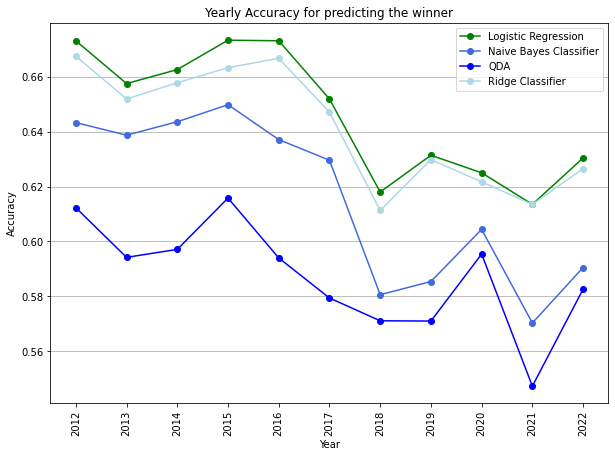

In [31]:
plt.figure(figsize = (10, 7))
plt.plot(df_lr['lr_Test_accuracy'], label = 'Logistic Regression', marker = 'o', color = 'green')
plt.plot(df_NB['NB_Test_accuracy'], label = 'Naive Bayes Classifier', marker = 'o', color = 'royalblue')
plt.plot(df_qda['qda_Test_accuracy'], label = 'QDA', marker = 'o', color = 'blue')
plt.plot(df_rc['rc_Test_accuracy'], label = 'Ridge Classifier', marker = 'o', color = 'lightblue')
plt.legend()
plt.xticks(rotation = 'vertical')
plt.xlabel('Year')
plt.ylabel('Accuracy')
plt.title('Yearly Accuracy for predicting the winner')
plt.grid(axis = 'y')
plt.show()

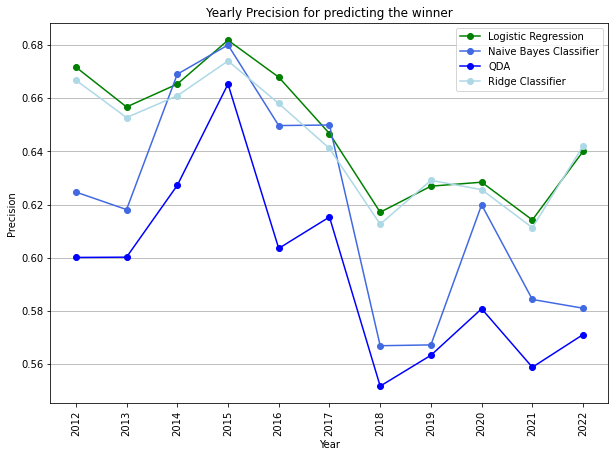

In [32]:
plt.figure(figsize = (10, 7))
plt.plot(df_lr['lr_Test_precision'], label = 'Logistic Regression', marker = 'o', color = 'green')
plt.plot(df_NB['NB_Test_precision'], label = 'Naive Bayes Classifier', marker = 'o', color = 'royalblue')
plt.plot(df_qda['qda_Test_precision'], label = 'QDA', marker = 'o', color = 'blue')
plt.plot(df_rc['rc_Test_precision'], label = 'Ridge Classifier', marker = 'o', color = 'lightblue')
plt.legend()
plt.xticks(rotation = 'vertical')
plt.xlabel('Year')
plt.ylabel('Precision')
plt.title('Yearly Precision for predicting the winner')
plt.grid(axis = 'y')
plt.show()

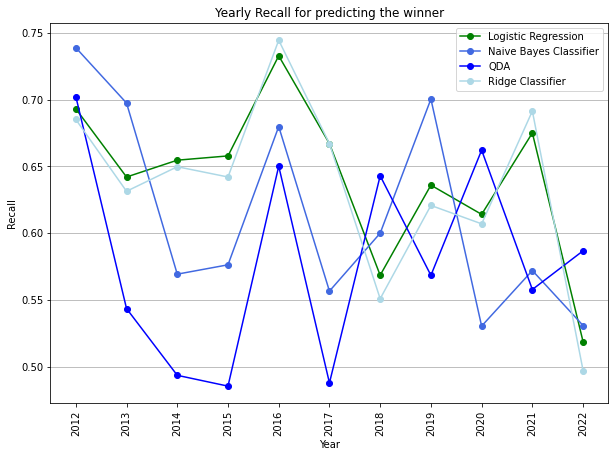

In [34]:
plt.figure(figsize = (10, 7))
plt.plot(df_lr['lr_Test_recall'], label = 'Logistic Regression', marker = 'o', color = 'green')
plt.plot(df_NB['NB_Test_recall'], label = 'Naive Bayes Classifier', marker = 'o', color = 'royalblue')
plt.plot(df_qda['qda_Test_recall'], label = 'QDA', marker = 'o', color = 'blue')
plt.plot(df_rc['rc_Test_recall'], label = 'Ridge Classifier', marker = 'o', color = 'lightblue')
plt.legend()
plt.xticks(rotation = 'vertical')
plt.xlabel('Year')
plt.ylabel('Recall')
plt.title('Yearly Recall for predicting the winner')
plt.grid(axis = 'y')
plt.show()